# Wikipedia pages graph from seed page

In [49]:
import networkx as nx
import wikipedia
from wikipedia import DisambiguationError, PageError
import matplotlib.pyplot as plt

Set the seed page and the search depth. The search depth is the number of
layers of neighbors to include in the network. e.g., if the search depth is 1,
the network will include the seed page and all pages linked from the seed page.

In [50]:
SEARCH_DEPTH = 1  #Set the search depth here                       
SEED = "Roma Tre"  #Set the seed page here

STOPS = ("International Standard Serial Number",
         "International Standard Book Number",
         "Geographic coordinate system",
         "National Diet Library",
         "International Standard Name Identifier",
         "International Standard Book Number (Identifier)",
         "Pubmed Identifier",
         "Pubmed Central",
         "Digital Object Identifier",
         "Arxiv",
         "Proc Natl Acad Sci Usa",
         "Bibcode",
         "Library Of Congress Control Number",
         "Jstor", "JSTOR (identifier)",
         "Doi (identifier)", "Doi (Identifier)",
         "Isbn (Identifier)", "Isbn (identifier)",
         "S2CID (identifier)",
         "Pmid (Identifier)",
         "Arxiv (Identifier)",
         "Bibcode (Identifier)")


## 1.1 Setting up fringe and visited sets

In [51]:
SEED = SEED.title()
fringe = [(0, SEED)]  # The queue of pages we have found but not yet visited
done_set = set()  # The set of pages we have visited
g = nx.DiGraph()  # The networkx graph, directed


## 1.2 Load the seed page
Check whether the seed page exists.

In [52]:
import sys

layer, page = 0, SEED

try:
    source = wikipedia.page(SEED, auto_suggest=False)
    done_set.add(SEED)
    print(source.url)
    print(f"Page loaded, adding {len(source.links)} subpages")
except (DisambiguationError, PageError):
    print(f"Could not load seed {SEED}")
    print("Check if the page exists.")
    sys.exit(1)

https://en.wikipedia.org/wiki/Newton-Smith
Page loaded, adding 5 subpages


In [53]:
def fetch_links(page):
    try:
        links = wikipedia.page(page).links
        return links
    except (DisambiguationError, PageError):
        print(f"Error retrieving links from {page}")
        return []

## 1.3 Build the network
Using Breadth First Search (BFS) to build the network.

In [54]:
%%time
from concurrent.futures import ThreadPoolExecutor

progress = {"nodes": [], "fringe": []}
with ThreadPoolExecutor() as executor:
    while fringe:
        layer, page = fringe.pop(0)
        done_set.add(page)
        print(f"{layer} - {page}, nodes: {len(done_set)}, fringe: {len(fringe)}")

        progress["nodes"].append(len(done_set))
        progress["fringe"].append(len(fringe))

        links = executor.submit(fetch_links, page).result()

        for link in links:
            g.add_edge(page, link)
            if link not in STOPS and link not in done_set and not link.startswith("List of"):
                done_set.add(link)
                if layer < SEARCH_DEPTH:
                    fringe.append((layer + 1, link))


0 - Newton-Smith, nodes: 1, fringe: 0
1 - Apple Newton-Smith, nodes: 6, fringe: 4
1 - Given name, nodes: 229, fringe: 226
1 - Rain Newton-Smith, nodes: 804, fringe: 800
1 - Surname, nodes: 815, fringe: 810
1 - William Newton-Smith, nodes: 1226, fringe: 1220
2 - ARM architecture, nodes: 1246, fringe: 1239
Error retrieving links from ARM architecture
2 - Acorn Computers, nodes: 1246, fringe: 1238
2 - All Things Digital, nodes: 1539, fringe: 1237
2 - Android operating system, nodes: 1790, fringe: 1236
2 - AppleCD, nodes: 2750, fringe: 1235
2 - AppleColor High-Resolution RGB Monitor, nodes: 2757, fringe: 1234
2 - Apple 410 Color Plotter, nodes: 3005, fringe: 1233
2 - Apple Adjustable Keyboard, nodes: 3011, fringe: 1232
2 - Apple AudioVision 14 Display, nodes: 3022, fringe: 1231
2 - Apple Bandai Pippin, nodes: 3036, fringe: 1230
2 - Apple ColorSync/AppleVision 750 Display, nodes: 3239, fringe: 1229
2 - Apple Communication Slot, nodes: 3239, fringe: 1228
2 - Apple Daisy Wheel Printer, nodes:

KeyboardInterrupt: 

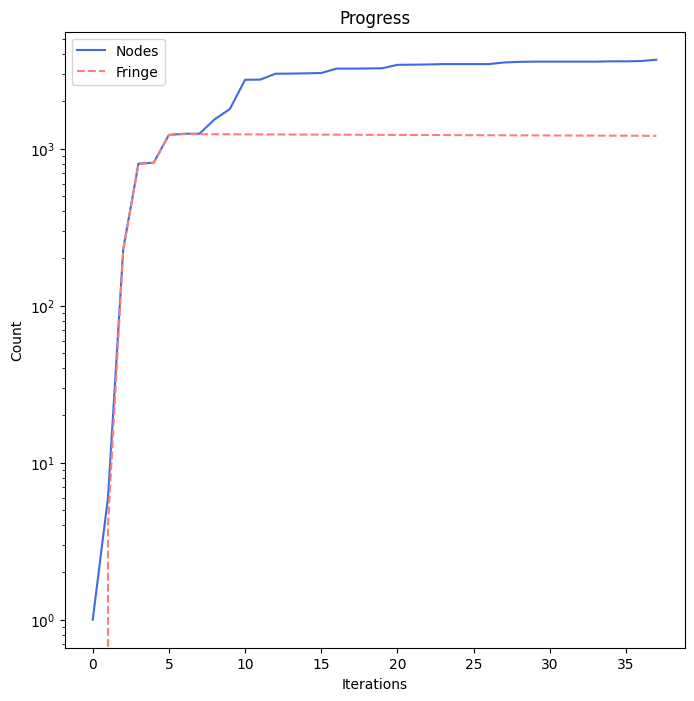

In [55]:
#plotting the progress
plt.figure("Progress", figsize=(8, 8))
plt.plot(progress["nodes"], label="Nodes", color="royalblue", linestyle="-")
plt.plot(progress["fringe"], label="Fringe", color="salmon", linestyle="--")
# log scale
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Count")
plt.title("Progress")
plt.legend()
plt.show()


In [56]:
print(f"{g.number_of_nodes()} nodes, {g.number_of_edges()} edges")

3736 nodes, 8211 edges


## 1.4 Explore the network

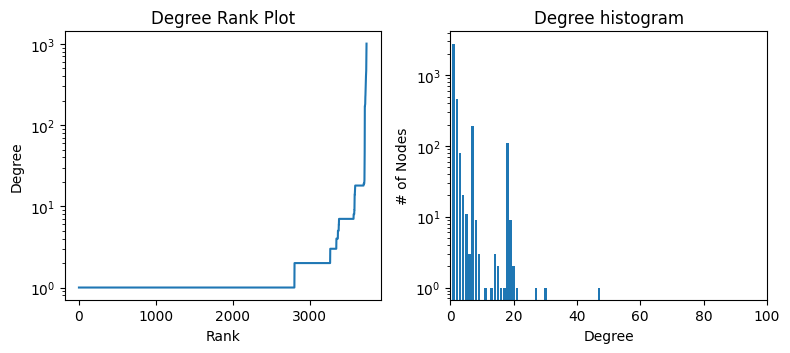

In [57]:
import numpy as np

degree_sequence = sorted((d for _, d in g.degree()))

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence)
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_yscale("log")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_xlim([0, 100])
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_yscale("log")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

## 1.5 Save the graph in Gephi readable format

In [58]:
nx.write_gexf(g, f"graphs/{SEED}_d{SEARCH_DEPTH}.gexf")